# Script to compare different sources of GPS information
This script takes in data in the form of `datetime`, `lat`, `long`, `id`, and then compares it to reference data (also in the same form).
See *Appendix A* at the bottom of this notebook for sample queries to collect lat/long data.

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// this makes the jupyter-notebook not generate a scrollbar when the cell is too big 

In [2]:
# this makes the Jupyter notebook wider to better display large charts
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from datetime import datetime, timedelta
import json

import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

from bokeh.layouts import row as bokeh_row
from bokeh.models import BoxAnnotation, ColumnDataSource, Label, WheelZoomTool, Span
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import get_provider, Vendors
from bokeh.io import output_notebook, export_png

from stevelib import snap_to_roads, haversine_np, convert_gpx_to_df, convert_sumo_to_df, convert_app_logs_to_df, convert_mensa_to_df, transform_wgs84_to_web_mercator, plot2, make_circle

output_notebook()  # for plotting to the notebook

Loading BokehJS ...

## Script parameters
These need to be modified.

In [4]:
# some files are in local time and need to be converted to UTC
# specify here the timezone those files are in
TIMEZONE = 'America/Los_Angeles'

SECONDS_BEFORE = -3*60  # plot points from many this seconds after the reference datatime
SECONDS_OFFSET = 1*60  # calculate the error this many seconds after the reference datatime
SECONDS_AFTER = 5*60  # plot points until this many seconds after the reference datatime

In [5]:
# temporary color map
# TODO: automate
colors = {
    'experimental': '#ff0000',
    'experimental_snap': '#00f0ff',
    '242': '#00ffff',  # Sameera
    '3VWCB7BU4KM159004': '#0000ff',
}

## Read in data from various sources
Read in the lat/long data from various sources (Sumo Logic, Periscope, Snap to roads, Mensa, GPX files, CSV files, etc.) and put them all into dataframe `df`.  Each file should have a column added called `label` which has a string which .

After import, `df` should have at least the following columns:
* `datetime` - Timezone-aware datetime of when the data point was captured
* `id` - String representing the source of the data point (VIN, customer_id, etc.) (needs to be the same ID used by the reference file (below))
* `label` - Friendlier alternate string for the source of the data point (license plate, customer's name, etc.)
* `lat` - Data point latitude as a float
* `long` - Data point longitude as a float

In [6]:
# experimental app, 
# read in data pipeline data for APP-LOCATION-UPDATE
# see appendix A
result = []
f = open('test_data/dhruva_APP-LOCATION-UPDATE.txt')
for line in f:
    data = json.loads(line)
    if data['name'] == 'APP-LOCATION-UPDATE':
        result.append([data['timestamp'], 'experimental', data['data']['user_location']['lat'], data['data']['user_location']['lng']])
df = pd.DataFrame(result, columns = ['datetime', 'id', 'lat', 'long'])
df['datetime'] = pd.to_datetime(df['datetime'])
df['id'] = df['id'].astype(str)
df['lat'] = df['lat'].astype(float)
df['long'] = df['long'].astype(float)
df['label'] = 'Experimental app'
df =  df.set_index('datetime').sort_index()

# vehicle CSM
# sumo unavailable!  have to use exported keycore xls->csv (with month/day flipped)
df_temp = pd.read_csv('test_data/synthesis (6).csv')
df_temp['datetime'] = pd.to_datetime(df_temp['datetime']).dt.tz_localize('UTC')  # <-- customize this!
df_temp['lat'] = df_temp['lat'].astype(float)
df_temp['long'] = df_temp['long'].astype(float)
df_temp['label'] = 'CSM'
df_temp = df_temp.set_index('datetime').sort_index()
df = df.append(df_temp, sort=False)

# snap to roads
df_temp = convert_app_logs_to_df('test_data/snap.csv')  # <-- run the snap to roads notebook first to get this csv!
df_temp['label'] = 'Snap to road'
df = df.append(df_temp, sort=False)

# final steps
df = df.sort_index()
df.tail()

,id,lat,long,label,Unnamed: 0
datetime,,,,,
2019-09-17 20:29:12+00:00,experimental,37.780884,-122.396304,Experimental app,NaN
2019-09-17 20:29:13+00:00,experimental,37.780792,-122.396379,Experimental app,NaN
2019-09-17 20:29:17+00:00,experimental,37.780792,-122.396379,Experimental app,NaN
2019-09-17 20:30:05+00:00,experimental,37.780792,-122.396379,Experimental app,NaN
2019-09-17 22:37:35+00:00,3VWCB7BU4KM159004,37.781000,-122.396440,CSM,NaN


## Read in reference data
While the data above is the test lat/long data, we also need to read in the reference ("correct") lat/long at each location (so we can compare against it).  Usually I import this data from a spreadsheet (CSV) into dataframe `ref`:

After import, `ref` should have at least the following columns:
* `datetime` - Timezone-aware datetime of the time of interest at the location (e.g. when the vehicle stopped moving, when the engine turned off, etc.)
* `ids` - Comma-separated string representing the sources of the data for that location (VIN, customer_id, etc.)
* `lat` - Latitude as a float
* `long` - Longitude as a float

In [7]:
# read in the reference csv (in this case exported from Google Sheets)
ref = pd.read_csv('test_data/9_17 Jetta Testing Daytona PROD  - no antenna.csv')
ref['datetime'] = pd.to_datetime(ref['stop time']).dt.tz_localize(TIMEZONE)  # <-- customize this!
ref['lat'] = ref['lat'].astype(float)
ref['long'] = ref['long'].astype(float)
ref['ids'] = ref['ids'].str.split(',')  # split the multiple ids into a list
ref = ref.drop(columns=['stop time'])

ref.head()

,ref,Name,Detailed description,record truepath,record mensa,record ota,photograph location,STOP ENGINE,engine turned off time,record mensa.1,record ota.1,parked time,engine turned on time,Unnamed: 14,leave time,ids,lat,long,datetime
0,1,Coco bang,NaN,x,x,x,x,x,12:36 PM,NaN,x,NaN,NaN,NaN,NaN,"[3VWCB7BU4KM159004, 242, experimental, experim...",37.787584,-122.411592,2019-09-17 12:35:00-07:00
1,2,mikaku sushi,NaN,x,x,x,x,x,12:43 PM,NaN,x,NaN,NaN,NaN,NaN,"[3VWCB7BU4KM159004, 242, experimental, experim...",37.790058,-122.405583,2019-09-17 12:43:00-07:00
2,3,alley,250 post brooks bros,x,x,x,x,x,12:50 PM,NaN,x,NaN,NaN,NaN,NaN,"[3VWCB7BU4KM159004, 242, experimental, experim...",37.788640,-122.406085,2019-09-17 12:50:00-07:00
3,4,golden gateway cleaners,NaN,x,x,x,x,x,1:02 PM,NaN,x,NaN,NaN,NaN,NaN,"[3VWCB7BU4KM159004, 242, experimental, experim...",37.795416,-122.400366,2019-09-17 13:07:00-07:00
4,5,one embarcadero center,"on clay, battery behind",x,x,x,x,x,1:07 PM,NaN,x,NaN,NaN,NaN,NaN,"[3VWCB7BU4KM159004, 242, experimental, experim...",37.796105,-122.398362,2019-09-17 13:02:00-07:00


## Analyze all the locations
At each location, we analyze the data points which have an `id` that match this location's `ids` field.  While all the points from `SECONDS_BEFORE` to `SECONDS_AFTER` the location's `datetime` are plotted, only the point `SECONDS_OFFSET` seconds after the location's `datetime` is actually evaluated.



In [8]:
error = []  # temp list holding the id and error 

for index, row in ref.iterrows():
    print(f'Index {index}')
    t_start = row['datetime'] + timedelta(seconds=SECONDS_BEFORE)
    t_target = row['datetime'] + timedelta(seconds=SECONDS_OFFSET)
    t_end = row['datetime'] + timedelta(seconds=SECONDS_AFTER)

    # draw the basic map
    p = figure(
        title="Location {} (target time =  {})".format(index+1, t_target),
#         plot_width=800, 
#         plot_height=800, 
        x_axis_type="mercator", 
        y_axis_type="mercator",
        match_aspect=True,  # make sure the map isn't skewed?
        tools="pan,wheel_zoom,reset")
    p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
    p.toolbar.active_scroll = p.select_one(WheelZoomTool) 
    p.xaxis.axis_label = "Longitude"
    p.yaxis.axis_label = "Latitude"

    
    p2 = figure(
#         title="Row {} @ {}: {} ({})".format(index+1, row.datetime, row['Inaccuracy Comfort'], row['VIN']),
#         plot_width=800, 
#         plot_height=800, 
        x_axis_type="datetime", 
        tools="pan,wheel_zoom,reset")
    p2.toolbar.active_scroll = p2.select_one(WheelZoomTool) 
    p2.xaxis.axis_label = "Time"
    p2.yaxis.axis_label = "Error [meters]"

    # plot the reference position
    plot2(p, 
          [row['lat']], 
          [row['long']], 
          color='#000000', 
          size=10, 
#           legend='Reference Position'
         )
    
    # plot the reference rings
    make_circle(p, row['lat'], row['long'], 10, line_width=2, line_color='green', line_alpha=0.25)
    make_circle(p, row['lat'], row['long'], 20, line_width=2, line_color='orange', line_alpha=0.25)
    make_circle(p, row['lat'], row['long'], 30, line_width=2, line_color='red', line_alpha=0.25)
    
    # select the points which belong to this ref location
    for id in row['ids']:
#         print(id)
        df_subset = df.loc[df['id'] == id][t_start:t_end]  # the subset for this id and this time frame
        
        if len(df_subset['label']) > 0:  # only do it if there's values
            # plot the points
            plot2(p, 
                  df_subset['lat'].values, 
                  df_subset['long'].values, 
#                   legend=df_subset['label'][0], 
                  color=colors[df_subset['id'][0]],
                  size=5, )
            
            # line graph of the points
            x2, y2 = transform_wgs84_to_web_mercator(df_subset['long'].values, df_subset['lat'].values) 
            source = ColumnDataSource({'x': x2, 'y': y2})
            p.line(x='x', y='y', color=colors[df_subset['id'][0]], alpha=0.5, source=source)

            # calculate the error for all these points
            df_subset['local_error'] = haversine_np(row['long'], row['lat'], df_subset['long'], df_subset['lat'])
            
#             print(df_subset)
            # select the last point nearest to the end time
            df_nearest = df_subset[:t_target]
        
            if len(df_nearest) > 0:
                df_nearest = df_nearest.iloc[-1]
                error.append([index, id, df_nearest['local_error'], df_nearest['label']])

                # plot the point that we're comparing even bigger!
                plot2(p, 
                      [df_nearest['lat']], 
                      [df_nearest['long']], 
    #                   legend=df_nearest['label'], 
                      color=colors[df_nearest['id']],
                      size=20, )

                ####
                # plot the errors versus time
                p2.circle(x=df_subset.index, y=df_subset['local_error'], color=colors[df_subset['id'][0]], legend=df_subset['label'][0])
                p2.circle(x=df_nearest.name, y=df_nearest['local_error'], color=colors[df_nearest['id']], size=20)  # the actual point used for error 
                source = ColumnDataSource({'x': df_subset.index, 'y': df_subset['local_error']})
                p2.line(x='x', y='y', color=colors[df_subset['id'][0]], alpha=0.5, source=source)

                p2.add_layout(Span(location=t_target, dimension='height', line_dash='solid', line_width=4))  # the time at which data is collected
                p2.add_layout(Span(location=t_start, dimension='height', line_dash='dashed', line_width=2))  # the time at which data is collected
                p2.add_layout(Span(location=t_end, dimension='height', line_dash='dashed', line_width=2))  # the time at which data is collected
    
    p0 = bokeh_row(p, p2)
    show(p0)
#     export_png(p0, filename=f'{index}.png')

error = pd.DataFrame(error, columns=['index', 'id', 'error', 'label'])    

Index 0


Index 1


Index 2


Index 3


Index 4


In [9]:
error.groupby('label')['error'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
CSM,5.0,7.196631,5.192209,2.532263,4.956261,5.552717,6.898300,16.043614
Experimental app,4.0,12.121372,5.796591,4.179241,10.455174,13.135454,14.801651,18.035341
Snap to road,5.0,48.550753,81.628787,6.776937,11.130501,12.839154,17.599024,194.408152


[Text(0, 0.5, 'Error [meters]'), Text(0.5, 0, '')]

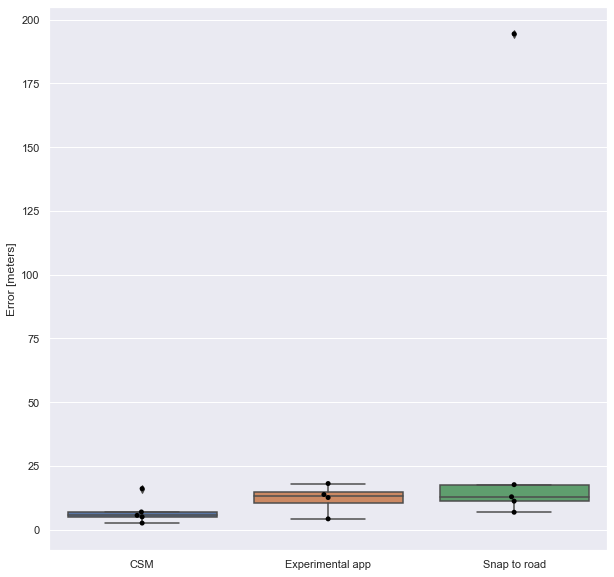

In [10]:
# plot the errors vs label
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.boxplot(y="error", x="label", data=error, showfliers=True)
sns.swarmplot(x="label", y="error", data=error, color="#000000")
ax.set(xlabel='', ylabel='Error [meters]')

[Text(0, 0.5, 'Error [meters]'), Text(0.5, 0, '')]

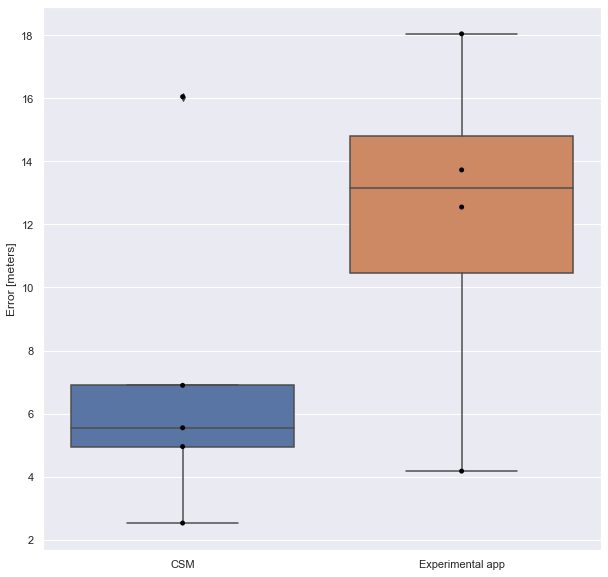

In [13]:
# plot the errors vs label
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.boxplot(y="error", x="label", data=error[error['label'] != 'Snap to road'], showfliers=True)
sns.swarmplot(x="label", y="error", data=error[error['label'] != 'Snap to road'], color="#000000")
ax.set(xlabel='', ylabel='Error [meters]')

# Appendix A
Commonly used queries for gathering lat/long data.
## Sumo Logic
Query which gets the lat/long of CSMs.
~~~~
cluster=daytona-prod
"'request_method': 'POST" "event_type': 'OTAKEYS_VEHICLE_SYNTHESIS"
| parse "body': '*', 'request_method" as body
//| json field=body "synthesis.isEngineRunning"
//| json field=body "operationCode"
//| json field=body "operationState"
| json field=body "synthesis.gpsInformation.latitude" as lat
| json field=body "synthesis.gpsInformation.longitude" as long
| json field=body "vehicle.extId" as id
| fields -_raw, body
~~~~

## Data pipeline 
Download the data from the data pipeline S3 buckets and concatenate all the files together into a single one.
~~~~
cat rawevents_daytona-qa_2019-09-17* > merged.txt
~~~